In [1]:
#import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

## Data Cleaning: 311 Air Quality Complaints
Note: aggregate by 6 month intervals and community district to match with NYC air quality data

In [2]:
#Source: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9
#filter for unique key - complaint type that contains 'air'
complaints_311=pd.read_csv("311_Service_Requests_from_2010_to_Present.csv")

In [3]:
complaints_311.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,42083877,03/29/2019 05:32:00 PM,04/03/2019 07:00:00 AM,DEP,Department of Environmental Protection,Air Quality,"Air: Smoke, Chimney or vent (AS1)",NaN,11211.0,427 BROADWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.706794,-73.953165,"(40.706793854142205, -73.9531654456665)"
1,42084205,03/29/2019 07:40:00 AM,04/04/2019 10:15:00 AM,DEP,Department of Environmental Protection,Air Quality,"Air: Odor/Fumes, Vehicle Idling (AD3)",NaN,10314.0,2218 VICTORY BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.612026,-74.137362,"(40.612026410048635, -74.13736166401263)"
2,42084263,03/29/2019 12:26:00 PM,04/01/2019 12:00:00 PM,DEP,Department of Environmental Protection,Air Quality,"Air: Smoke, Vehicular (AA4)",NaN,11365.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.746966,-73.798261,"(40.74696639197899, -73.79826063805075)"
3,42084559,03/29/2019 10:49:06 AM,04/01/2019 09:25:28 AM,DOHMH,Department of Health and Mental Hygiene,Indoor Air Quality,Chemical Vapors/Gases/Odors,3+ Family Apartment Building,10452.0,1459 WYTHE PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.840561,-73.914173,"(40.84056093412579, -73.9141730061352)"
4,42084836,03/29/2019 01:14:00 AM,04/02/2019 10:31:00 AM,DEP,Department of Environmental Protection,Air Quality,"Air: Smoke, Chimney or vent (AS1)",NaN,10128.0,EAST 96 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#check unique complaint types
complaints_311['Complaint Type'].value_counts()
#remove indoor air quality, maybe we'll want to include later
complaints_311 = complaints_311.loc[complaints_311['Complaint Type'] == 'Air Quality']
#check number of records
len(complaints_311)

81370

In [5]:
complaints_311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [6]:
#edit and create date columns to aggegreate air quality complaints by date and season
complaints_311['Created Date'] = pd.to_datetime(complaints_311['Created Date'])
complaints_311['date'] = complaints_311['Created Date'].dt.date
complaints_311['year'] = complaints_311['Created Date'].dt.year
complaints_311['month'] = complaints_311['Created Date'].dt.month
complaints_311['day'] = complaints_311['Created Date'].dt.day
#create season column - note: months 12-5 are winter and 6-11 are summer
complaints_311['season'] = 'winter'
complaints_311.loc[(complaints_311['month'] > 5) & (complaints_311['month'] < 12), 'season'] = 'summer'
#check to make sure worked - looks good
#complaints_311.loc[(complaints_311['season'] == 'summer')]

In [7]:
complaints_311['Incident Zip'].value_counts()

10025.0    2085
10003.0    2044
11375.0    1737
10024.0    1653
10019.0    1493
           ... 
10152.0       1
10153.0       1
10155.0       1
10165.0       1
10271.0       1
Name: Incident Zip, Length: 207, dtype: int64

In [8]:
import geopandas as gpd

In [9]:
cd = gpd.read_file('data/shp/nycd.shp')
cd.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,101,74168.587892,4.268912e+07,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,102,34130.595277,3.768921e+07,"POLYGON ((985125.733 207917.071, 986018.960 20..."
2,103,30695.640963,4.687978e+07,"POLYGON ((992073.467 203714.076, 992068.667 20..."
3,104,67623.669901,4.931172e+07,"POLYGON ((985929.324 220967.002, 985995.954 22..."
4,105,35288.188510,4.379033e+07,"POLYGON ((991725.244 217725.299, 992169.505 21..."


## Time Series Analysis: 311 Air Quality Complaints

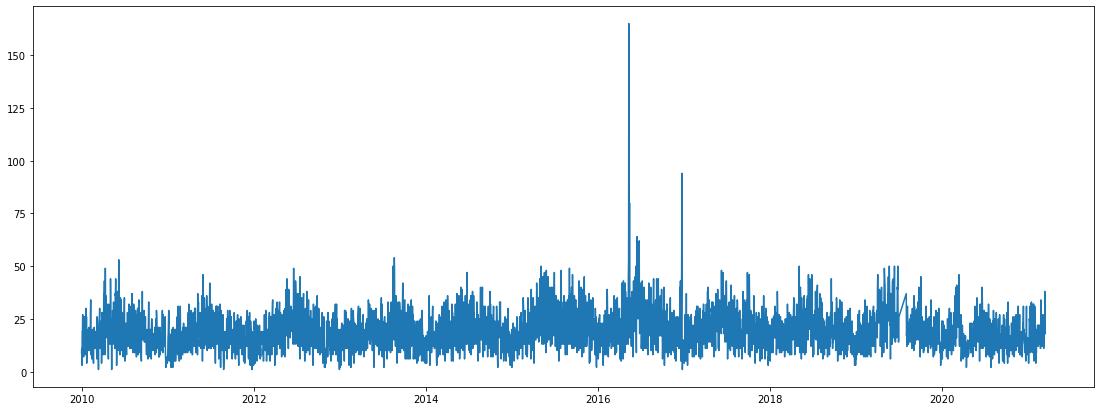

In [11]:
#first do general time series analysis (across all geographies) by day to see if we can detect overall trend
complaintsDaily = complaints_311['date'].groupby(complaints_311['date']).count().reset_index(name='count')
complaintsDaily
plt.figure(figsize = (19,7))
plt.plot(complaintsDaily['date'],complaintsDaily['count'])

Looks uniform with an two spikes in 311 complaints happening during 2016 & 2017. Next, look at linear regression to see if we can determine a trend over the past 10 years. Also check trend for the past three years that we have AQ measurements (2017 and onwards) --- make sure to check this date with the group!

In [12]:
lm_total=sm.OLS(complaintsDaily['count'],sm.add_constant(complaintsDaily.index)).fit()
print(lm_total.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.66
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           0.000222
Time:                        10:32:04   Log-Likelihood:                -14868.
No. Observations:                4051   AIC:                         2.974e+04
Df Residuals:                    4049   BIC:                         2.975e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1310      0.299     64.082      0.0

In [13]:
complaintsDaily.dtypes

date     object
count     int64
dtype: object

In [16]:
from datetime import date

complaintsDaily['date'] = pd.to_datetime(complaintsDaily['date'])
pd.Timestamp(date(2002,1,1))

Timestamp('2002-01-01 00:00:00')

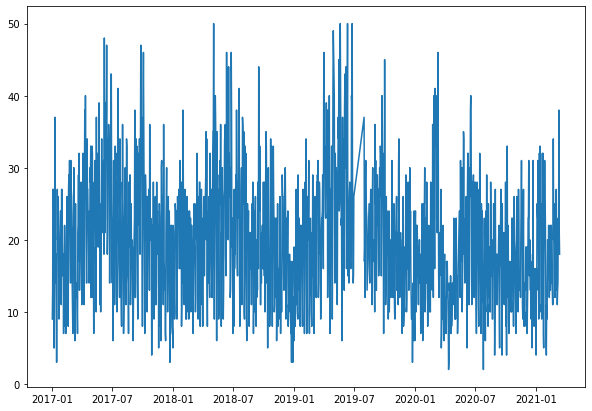

In [17]:
#now let's look over the past three years
complaintsDaily_current = complaintsDaily.loc[complaintsDaily['date'] > pd.Timestamp(date(2017,1,1))]
plt.figure(figsize = (10,7))
plt.plot(complaintsDaily_current['date'],complaintsDaily_current['count'])

In [18]:
complaintsDaily_current.head()

,date,count
2555,2017-01-02,9
2556,2017-01-03,13
2557,2017-01-04,27
2558,2017-01-05,27
2559,2017-01-06,24


In [19]:
lm_current=sm.OLS(complaintsDaily_current['count'],sm.add_constant(complaintsDaily_current.index)).fit()
print(lm_current.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     32.45
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           1.47e-08
Time:                        10:32:21   Log-Likelihood:                -5348.0
No. Observations:                1496   AIC:                         1.070e+04
Df Residuals:                    1494   BIC:                         1.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7318      1.723     17.254      0.0

Now, aggregate complaint counts by community district and and sum to get seasonal (bi-yearly) records.

In [20]:
import geopandas as gpd
# community districts shapefile
cd = gpd.read_file('data/shp/nycd.shp')
#geometry to first column
cd = cd[['geometry','BoroCD','Shape_Leng','Shape_Area']]
cd.head()

,geometry,BoroCD,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((972081.788 190733.467, 972184....",101,74168.587892,4.268912e+07
1,"POLYGON ((985125.733 207917.071, 986018.960 20...",102,34130.595277,3.768921e+07
2,"POLYGON ((992073.467 203714.076, 992068.667 20...",103,30695.640963,4.687978e+07
3,"POLYGON ((985929.324 220967.002, 985995.954 22...",104,67623.669901,4.931172e+07
4,"POLYGON ((991725.244 217725.299, 992169.505 21...",105,35288.188510,4.379033e+07


In [21]:
#creating new data frame with complaint ID and longitude + latitude to match the geojson
complaint_locations = complaints_311[['Unique Key', 'Latitude', 'Longitude']].copy() 
gdf = gpd.GeoDataFrame(complaint_locations,crs='EPSG:4326', geometry=gpd.points_from_xy(complaint_locations.Longitude, complaint_locations.Latitude))
#gdf.crs= 'ESPG:4326'
#remove Nans
gdf = gdf.dropna()
gdf.head()

,Unique Key,Latitude,Longitude,geometry
0,42083877,40.706794,-73.953165,POINT (-73.95317 40.70679)
1,42084205,40.612026,-74.137362,POINT (-74.13736 40.61203)
2,42084263,40.746966,-73.798261,POINT (-73.79826 40.74697)
6,42085451,40.696145,-73.743390,POINT (-73.74339 40.69614)
7,42085452,40.704178,-73.897365,POINT (-73.89736 40.70418)


In [22]:
complaints_311.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,date,year,month,day,season
0,42083877,2019-03-29 17:32:00,04/03/2019 07:00:00 AM,DEP,Department of Environmental Protection,Air Quality,"Air: Smoke, Chimney or vent (AS1)",NaN,11211.0,427 BROADWAY,...,NaN,NaN,40.706794,-73.953165,"(40.706793854142205, -73.9531654456665)",2019-03-29,2019,3,29,winter
1,42084205,2019-03-29 07:40:00,04/04/2019 10:15:00 AM,DEP,Department of Environmental Protection,Air Quality,"Air: Odor/Fumes, Vehicle Idling (AD3)",NaN,10314.0,2218 VICTORY BOULEVARD,...,NaN,NaN,40.612026,-74.137362,"(40.612026410048635, -74.13736166401263)",2019-03-29,2019,3,29,winter
2,42084263,2019-03-29 12:26:00,04/01/2019 12:00:00 PM,DEP,Department of Environmental Protection,Air Quality,"Air: Smoke, Vehicular (AA4)",NaN,11365.0,NaN,...,NaN,NaN,40.746966,-73.798261,"(40.74696639197899, -73.79826063805075)",2019-03-29,2019,3,29,winter
4,42084836,2019-03-29 01:14:00,04/02/2019 10:31:00 AM,DEP,Department of Environmental Protection,Air Quality,"Air: Smoke, Chimney or vent (AS1)",NaN,10128.0,EAST 96 STREET,...,NaN,NaN,NaN,NaN,NaN,2019-03-29,2019,3,29,winter
6,42085451,2019-03-29 03:00:00,04/01/2019 01:11:00 PM,DEP,Department of Environmental Protection,Air Quality,"Air: Odor/Fumes, Vehicle Idling (AD3)",NaN,11411.0,216-02 LINDEN BOULEVARD,...,NaN,NaN,40.696145,-73.743390,"(40.6961448394419, -73.74339016602585)",2019-03-29,2019,3,29,winter


In [23]:
joined_complaints = gpd.sjoin(gdf, cd, op='intersects', how='inner')
#you can stop here i just ran the bit below to check if it works
#test = joined_complaints.groupby('BoroCD')['Unique Key'].count().reset_index() #just a random df to test if this works
#test.head()
joined_complaints.head()

,Unique Key,Latitude,Longitude,geometry,index_right,BoroCD,Shape_Leng,Shape_Area


In [24]:
#visualize complaints by season
complaints_seasonal = complaints_311.groupby(['year','season'])['Unique Key'].count().reset_index()
complaints_seasonal.head()

#plot
plt.figure(figsize = (10,7))
plt.plot(complaints_seasonal['year'], complaints_seasonal['Unique Key'])

,year,season,Unique Key
0,2010,summer,3553
1,2010,winter,3290
2,2011,summer,3369
3,2011,winter,3036
4,2012,summer,3581


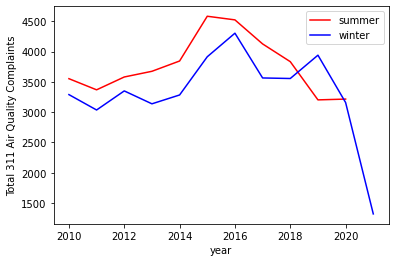

In [34]:
#separate df for summer and winter to plot
complaints_summer = complaints_seasonal.loc[complaints_seasonal['season'] == 'summer']
complaints_summer = complaints_summer[['year','Unique Key']]
complaints_winter = complaints_seasonal.loc[complaints_seasonal['season'] == 'winter']
complaints_winter = complaints_winter[['year','Unique Key']]

#plot
plt.plot(complaints_summer.year, complaints_summer['Unique Key'], color='red', label='summer')
plt.plot(complaints_winter.year, complaints_winter['Unique Key'], color='blue', label= 'winter')

plt.xlabel('year')
plt.ylabel('Total 311 Air Quality Complaints')
plt.legend()

In [25]:
#will make more of a difference when we have this amount
len(complaints_seasonal)

23

## Time Series Analysis: EPA Air Quality Measurements

In [26]:
#load data sets
#EPA air quality data
EPA_NO2 = pd.read_csv('EPA_NO2_cleaned.csv')
EPA_O3 = pd.read_csv('EPA_O3_cleaned.csv')
EPA_PM = pd.read_csv('EPA_PM_cleaned.csv')
EPA_SO2 = pd.read_csv('EPA_SO2_cleaned.csv')
#NYC air quality data. Note: at the CD & seasonal resolution

#Note:clean and process 311 Air Quality complaints below to get appropriate spatial/temporal resoluation (CD & seasonal)

                            OLS Regression Results                            
Dep. Variable:        Arithmetic Mean   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     142.9
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           1.65e-32
Time:                        10:32:49   Log-Likelihood:                -17772.
No. Observations:                5223   AIC:                         3.555e+04
Df Residuals:                    5221   BIC:                         3.556e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.8207      0.574     38.017      0.0

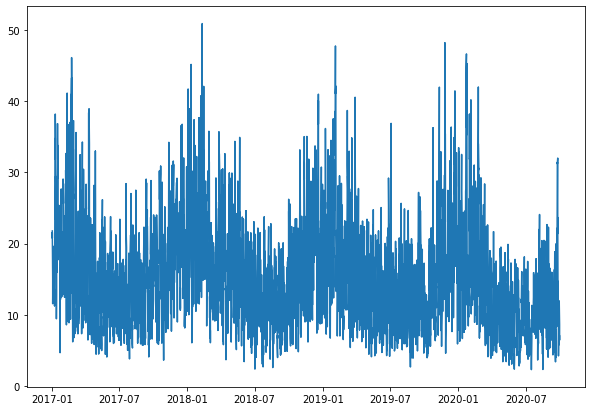

In [27]:
from datetime import date

#NO2
EPA_NO2_current = EPA_NO2[['Date Local','Arithmetic Mean']].copy()
EPA_NO2_current['Date Local'] = pd.to_datetime(EPA_NO2_current['Date Local'])
EPA_NO2_current = EPA_NO2_current.loc[EPA_NO2_current['Date Local'] > pd.Timestamp(date(2017,1,1))]

#regression over time
lm_NO2=sm.OLS(EPA_NO2_current['Arithmetic Mean'],sm.add_constant(EPA_NO2_current.index)).fit()
print(lm_NO2.summary())

#plot
plt.figure(figsize = (10,7))
plt.plot(EPA_NO2_current['Date Local'], EPA_NO2_current['Arithmetic Mean'])

                            OLS Regression Results                            
Dep. Variable:        Arithmetic Mean   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     48.38
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           3.88e-12
Time:                        10:32:51   Log-Likelihood:                 19268.
No. Observations:                6233   AIC:                        -3.853e+04
Df Residuals:                    6231   BIC:                        -3.852e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0206      0.001     20.266      0.0

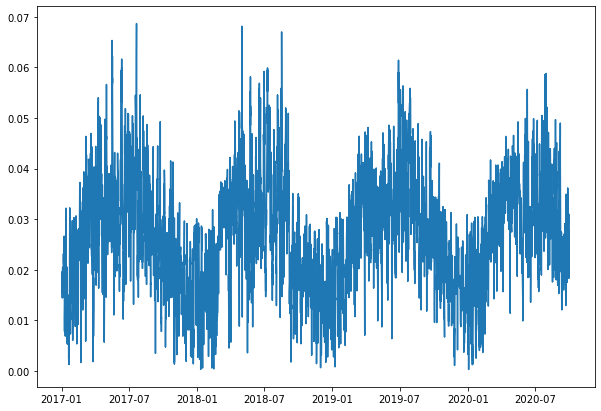

In [28]:
#O3
EPA_O3_current = EPA_O3[['Date Local','Arithmetic Mean']].copy()
EPA_O3_current['Date Local'] = pd.to_datetime(EPA_O3_current['Date Local'])
EPA_O3_current = EPA_O3_current.loc[EPA_O3_current['Date Local'] > pd.Timestamp(date(2017,1,1))]

#regression over time
lm_O3=sm.OLS(EPA_O3_current['Arithmetic Mean'],sm.add_constant(EPA_O3_current.index)).fit()
print(lm_O3.summary())
#plot
plt.figure(figsize = (10,7))
plt.plot(EPA_O3_current['Date Local'], EPA_O3_current['Arithmetic Mean'])


                            OLS Regression Results                            
Dep. Variable:        Arithmetic Mean   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     325.5
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           2.16e-71
Time:                        10:32:52   Log-Likelihood:                -4700.4
No. Observations:                8176   AIC:                             9405.
Df Residuals:                    8174   BIC:                             9419.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0518      0.033     32.197      0.0

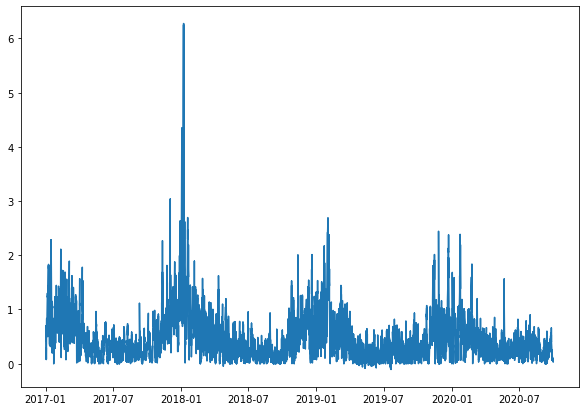

In [29]:
#SO2
EPA_SO2_current = EPA_SO2[['Date Local','Arithmetic Mean']].copy()
EPA_SO2_current['Date Local'] = pd.to_datetime(EPA_SO2_current['Date Local'])
EPA_SO2_current = EPA_SO2_current.loc[EPA_SO2_current['Date Local'] > pd.Timestamp(date(2017,1,1))]
#regression over time
lm_SO2=sm.OLS(EPA_SO2_current['Arithmetic Mean'],sm.add_constant(EPA_SO2_current.index)).fit()
print(lm_SO2.summary())
#plot
plt.figure(figsize = (10,7))
plt.plot(EPA_SO2_current['Date Local'], EPA_SO2_current['Arithmetic Mean'])

                            OLS Regression Results                            
Dep. Variable:        Arithmetic Mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.875
Date:                Fri, 16 Apr 2021   Prob (F-statistic):              0.171
Time:                        10:32:52   Log-Likelihood:                -25840.
No. Observations:                9059   AIC:                         5.168e+04
Df Residuals:                    9057   BIC:                         5.170e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7945      0.278     24.407      0.0

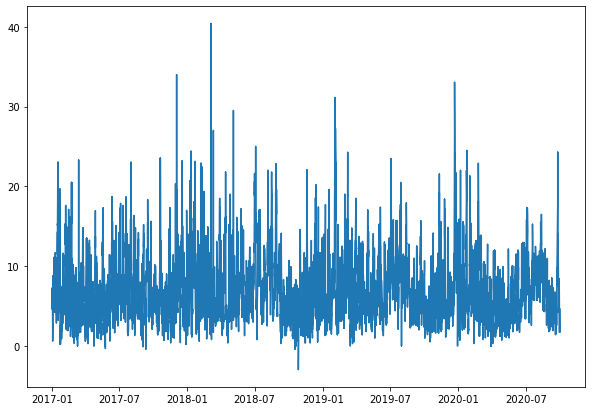

In [30]:
#PM
EPA_PM_current = EPA_PM[['Date Local','Arithmetic Mean']].copy()
EPA_PM_current['Date Local'] = pd.to_datetime(EPA_PM_current['Date Local'])
EPA_PM_current = EPA_PM_current.loc[EPA_PM_current['Date Local'] > pd.Timestamp(date(2017,1,1))]
#regression over time
lm_PM=sm.OLS(EPA_PM_current['Arithmetic Mean'],sm.add_constant(EPA_PM_current.index)).fit()
print(lm_PM.summary())
#plot
plt.figure(figsize = (10,7))
plt.plot(EPA_PM_current['Date Local'], EPA_PM_current['Arithmetic Mean'])